/var/folders/jj/9j0c_6196zx24tx5jb3ngnym0000gn/T/ipykernel_37605/1365286378.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval = interval, period = PERIOD)
[*********************100%***********************]  1 of 1 completed


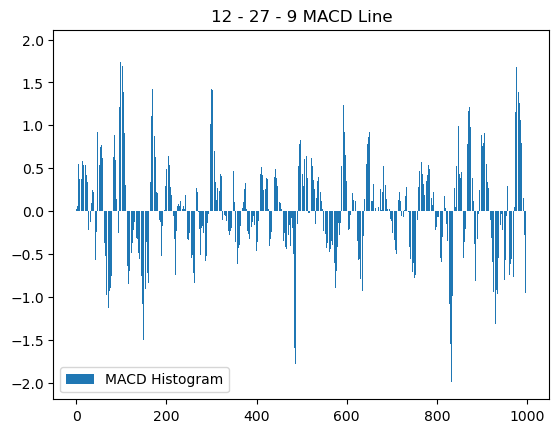

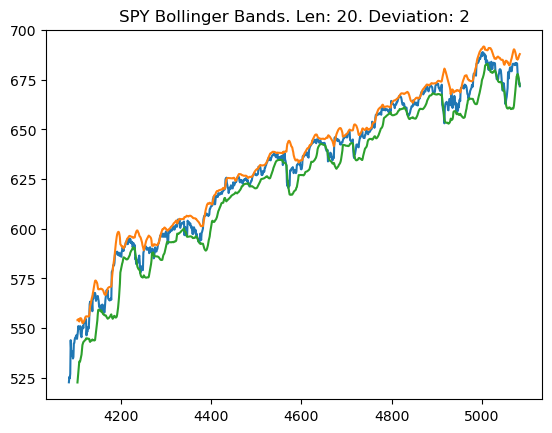

In [ ]:
import numpy as np 
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Step 1: Ticker
TICKER = "SPY"

# Step 2: Price Behavior 
INTERVAL = "1h"
if INTERVAL == "1h":
    PERIOD = "730d"
else:
    PERIOD = "max"

# Step 3: MACD
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

# Step 4: BB
BB_LENGTH = 20
STD_DEV = 2

# Step 5: Data Subsection
LOOKBACK = 1000

def get_data(ticker = TICKER, interval = INTERVAL, lookback = LOOKBACK):
    
    # Step 1: Download Data
    df = yf.download(ticker, interval = interval, period = PERIOD)

    # Step 2: Select only Level 1 from Multilevel Column (MultiIndex)
    df.columns = df.columns.get_level_values(0)

    # Step 3: Simplifying df for Plots
    df = df.reset_index(drop=True)

    # Step 4: Return Subsect Data 
    return df.iloc[-lookback:, :]

def add_MACD(df, fast = MACD_FAST, slow = MACD_SLOW, span = MACD_SPAN):

    # Step 1: Fast and Slow EMA Columns
    df[f"{fast}_ema"] = df["Close"].ewm(span = fast).mean()
    df[f"{slow}_ema"] = df["Close"].ewm(span = slow).mean()

    # Step 2: MACD Column (= Difference betwenn fast and slow ema)
    df["MACD"] = df[f"{fast}_ema"] - df[f"{slow}_ema"]

    # Step 3: MACD Signal (= Span Period)
    df["Signal"] = df[f"MACD"].ewm(span = span).mean()

    # Step 4: MACD Hist
    df["MACD_HIST"] = df[f"MACD"] - df["Signal"]

    # Step 5: Plot Histogram
    plt.figure()
    plt.bar(x=range(len(df)), height=df["MACD_HIST"])
        # Every Bar = Every Date in the Index
        # Direction: Bar (>0) --> Bullish vs. Bar (<0) --> Bearish
        # Strength: Bar (Tall) --> Strong Momentum vs. Bar (Short) --> Weak Momentum
    plt.title(f"{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Line")
    plt.legend(["MACD Histogram"])

    return df

def add_bollinger_bands(df, std_dev = STD_DEV, length = BB_LENGTH):
        
    # Step 1: Build the BB Columns
    df["BB_SMA"] = df["Close"].rolling(window=length).mean()
        # It calculates the middle Bend
        # rolling(window=length): it takes the Close price and creates a moving window of length periods
        # mean(): it calculates the average price within that window at each step
    df["BB_STD"] = df["Close"].rolling(window=length).std()
        # std. dev/volatility: quantifies how spread out/ inconsistent your data is. 
        # It measures the average distance of each data point from the mean of the entire set
    df["Upper Band"] = df["BB_SMA"] + (std_dev * df["BB_STD"])
        # It takes the middle band's value and adds the volatility * std_dev factor (typically 2). 
        # This places the upper line 2 std_dev above the middle band.
    df["Lower Band"] = df["BB_SMA"] - (std_dev * df["BB_STD"])
        
    # Step 2: Plot the BB
    plt.figure()
    plt.plot(df["Close"]) # Blue
    plt.plot(df["Upper Band"]) # Orange
    plt.plot(df["Lower Band"]) # Green
    plt.title(f"{TICKER} Bollinger Bands. Len: {BB_LENGTH}. Deviation: {STD_DEV}")

    return df.dropna()
    # Drop na, since it takes us 20 days to get the first rollings average values 



def main():
    df = get_data()
    df = add_MACD(df)
    df = add_bollinger_bands(df)

    return df

df = main()
